# Imports

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from numpy.fft import fft, fftfreq
from sklearn.metrics import recall_score, make_scorer
from sklearn.model_selection import cross_validate
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

LE_MAGIC_NUM = 42
rng = np.random.default_rng(LE_MAGIC_NUM)

os.environ['PYTHONHASHSEED'] = str(LE_MAGIC_NUM)

import random
random.seed(LE_MAGIC_NUM)

np.random.seed(LE_MAGIC_NUM)

tf.random.set_seed(LE_MAGIC_NUM)

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
tf.test.is_built_with_cuda()

# Utilities

In [ ]:
def sensitivity_specificity(cf_matrix):
  if cf_matrix.shape[0] == 1:
    return np.array([1, 1])
  TN = cf_matrix[0][0]
  FP = cf_matrix[0][1]
  TP = cf_matrix[1][1]
  FN = cf_matrix[1][0]

  sensitivity = TP/(TP+FN) if TP & FN else 0
  specificity = TN/(TN+FP) if TN & FP else 0
  return sensitivity, specificity

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(20,4))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation acc')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def draw_confusion_matrix(cf_matrix):

  df_cm = pd.DataFrame(cf_matrix, index = [i for i in "01"],
                columns = [i for i in "01"])
  ax = plt.subplot()
  sns.heatmap(df_cm, annot=True, fmt = ".1f", ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  TN = cf_matrix[0][0]
  FP = cf_matrix[0][1]
  TP = cf_matrix[1][1]
  FN = cf_matrix[1][0]
  print(f'Sensitivity: {TP/(TP+FN)}, Specificity: {TN/(TN+FP)}\n')
  # print(f'True positive samples: {TP} (These are the FOG samples we classified FOG)')
  # print(f'False positive samples: {FP} (These are normal samples we classified as FOG)')
  # print(f'True negative samples: {TN} (These are the normal samples we classified as normal)')
  # print(f'False negative samples: {FN} (These are the FOG samples we classified as normal)')

# Read and Clean Data

Reading txt files as dataframes, adding headers

In [ ]:
dataframes = dict(zip(range(1,11), [list() for x in range(1,11)]))

path = 'daphnet/dataset'
file_names = os.listdir(path)
col_names = ['time', 'ank_hor_fwd', 'ank_vert', 'ank_hor_lat', 'leg_hor_fwd', 'leg_vert', 'leg_hor_lat', 
             'trunk_hor_fwd', 'trunk_vert', 'trunk_hor_lat', 'label']
feature_col_names = col_names[1:10]

for name in file_names:
  splits = name.split('R')
  num = int(splits[0][1:])
  df = pd.read_csv(os.path.join(path,name),  delimiter=' ', names=col_names, header=None)

  # Remove instances where session hasn't started and decrement all labels by 1
  df = df[df['label'] != 0]
  df['label'] -= 1

  dataframes[num].append(df)

In [ ]:
dataframes[8][0]

Remove patients 4 and 10 without any freezing episodes

In [ ]:
dataframes.pop(4)
dataframes.pop(10)

# Remove Outliers

In [ ]:
dfs_no_outliers = dict(zip(dataframes.keys(), [list() for x in dataframes.keys()]))

for i, subject in dataframes.items():
    for j, session in enumerate(subject):
        features = session[feature_col_names]
        
        for col in features.columns:
            features[col][
              (features[col] < features[col].median(axis=0) - features[col].std(axis=0) * 4) |
              (features[col] > features[col].median(axis=0) + features[col].std(axis=0) * 4)
            ] = features[col].median()
        session.loc[:, feature_col_names] = features
        dfs_no_outliers[i].append(session)


In [ ]:
dfs_no_outliers[8][0]['label'].value_counts()

# Feature Extraction

In [ ]:
SAMPLE_RATE = 64 # Sample rate in herz
STEP_SIZE = 4 # Step size in samples
WINDOW_LENGTH = 256
POWER_THRESHOLD = 2 ** 12
# sensors = ['trunk_hor_fwd', 'trunk_vert', 'trunk_hor_lat']
sensors = ['ank_hor_fwd', 'ank_vert', 'ank_hor_lat', 'leg_hor_fwd', 'leg_vert', 'leg_hor_lat', 'trunk_hor_fwd', 'trunk_vert', 'trunk_hor_lat']

Iterates through each sensor axis in a 4-second window and extract 256 samples with a 32 step increment

In [ ]:
def integrate(x, SR):
  return ( (sum(x[1:]) / SR) + (sum(x[:-1]) / SR) ) / 2

def is_standing(y):
  NFFT = WINDOW_LENGTH
  locomotion_band = [0.5, 3]
  freeze_band = [3, 8]

  f_res = SAMPLE_RATE / NFFT
  f_nr_LBs  = round(locomotion_band[0] / f_res) - 1 # -1 to match with baechlin's matlab functions (one indexed)
  f_nr_LBe  = round(locomotion_band[1] / f_res)
  f_nr_FBs  = round(freeze_band[0] / f_res) - 1
  f_nr_FBe  = round(freeze_band[1] / f_res)

  # Get signal inside window
  y -= y.mean() # Make signal zero-mean, removing DC component

  # Compute FFT and its real number equivalent
  Y = fft(y, NFFT)
  Pyy = Y * Y.conjugate()

  # Area Under Curve (AUC) of the locomotion and freeze band
  area_loco_band = integrate(Pyy[f_nr_LBs:f_nr_LBe].real / NFFT, SAMPLE_RATE)
  area_freeze_band = integrate(Pyy[f_nr_FBs:f_nr_FBe].real / NFFT, SAMPLE_RATE)

  return (area_loco_band + area_freeze_band) < POWER_THRESHOLD

def extract_features(data, labels):
  window_num = int(np.floor((len(data) - WINDOW_LENGTH + STEP_SIZE) / STEP_SIZE))

  # initialize feature dict
  windowed_data = np.full((window_num, WINDOW_LENGTH, len(sensors)), np.nan)
  window_labels = np.full(window_num, np.nan)

  current_pos = WINDOW_LENGTH;
  for i in range(window_num):
    start = current_pos - WINDOW_LENGTH
    window = data.iloc[start:current_pos]
    
    # uses trunk horizontal axis to check if subject is standing or actually freezing (Moore's idea) 
    if not is_standing(window['trunk_hor_fwd']):
      windowed_data[i] = window
      window_labels[i] = labels.iloc[start:current_pos].value_counts().index.values[0].astype(int)
    current_pos += STEP_SIZE
  
  return windowed_data, window_labels

In [ ]:
def process_dataframes(dfs):
    subjects_dfs = dict(zip(dataframes.keys(), [pd.DataFrame() for x in dataframes.keys()]))
    # Iterate through dataset subjects, subject sessions and subject sensors' 
    # axis measurements in a session                    
    for i, subject in dfs.items():
        print(f'Patient {i}')

        subject_df = np.empty((1,WINDOW_LENGTH, len(sensors)))
        subject_df = np.delete(subject_df, (0), axis=0)
        subject_y = []

        for j, session_data in enumerate(subject):
            sensor_data = session_data.loc[:, sensors]
            print(f' Session {j}')

            session_windows, session_labels = extract_features(sensor_data, session_data['label'])
            subject_df = np.vstack((subject_df, session_windows))
            subject_y = np.concatenate((subject_y, session_labels), axis=0)

        window_num = subject_df.shape[0]
        subject_reshape = subject_df.reshape((window_num * WINDOW_LENGTH, len(sensors)))
        subject_no_nan = subject_reshape[~np.isnan(subject_reshape).any(axis=1)]
        clean_y = subject_y[~np.isnan(subject_y)]

        label_index = pd.MultiIndex.from_product([clean_y, np.arange(WINDOW_LENGTH)], names=['label','time_step'])
        subjects_dfs[i] = pd.DataFrame(subject_no_nan, columns=sensors, index=label_index)
    return subjects_dfs

windowed_dataframes = process_dataframes(dataframes)

In [ ]:
windowed_dataframes

In [ ]:
freq_df = pd.concat(windowed_dataframes, names=['subject'])

In [ ]:
freq_df

# Train Test Split

In [ ]:
def normalize_df(df):
  normalized_df=(df-df.min())/(df.max()-df.min())
  return normalized_df

In [ ]:
subjects = set(windowed_dataframes.keys())

TEST_NUM = 1

test_subjects = set(rng.choice(list(windowed_dataframes.keys()), TEST_NUM))
while len(test_subjects) != TEST_NUM:
    test_subjects = set(rng.choice(list(windowed_dataframes.keys()), TEST_NUM))
train_subjects = subjects - test_subjects

# least unbalanced subject goes to testing
# train_subjects = [1,2,3,5,6,7,8]
# test_subjects = [9]
train_subjects = [1,2,3,5,6,7,9]
test_subjects = [8]

print(train_subjects, test_subjects)

index_frame = freq_df.index.to_frame()

train_df = freq_df[index_frame['subject'].isin(train_subjects)]
test_df = freq_df[index_frame['subject'].isin(test_subjects)]

X_train = train_df.values.reshape((int(train_df.shape[0] / WINDOW_LENGTH), WINDOW_LENGTH, train_df.shape[1]))
# X_train = normalize_df(X_train)
X_test = test_df.values.reshape((int(test_df.shape[0] / WINDOW_LENGTH), WINDOW_LENGTH, test_df.shape[1]))
# X_test = normalize_df(X_test)
y_train = pd.Series(train_df.index.get_level_values(1).values.astype(int))
y_train = y_train[range(0, y_train.shape[0], WINDOW_LENGTH)]
y_test = pd.Series(test_df.index.get_level_values(1).values.astype(int))
y_test = y_test[range(0, y_test.shape[0], WINDOW_LENGTH)]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

In [ ]:
y_test.value_counts()

# Undersampling

In [ ]:
y_train.value_counts()

In [ ]:
pd.Series(y_train.value_counts()).plot.bar()

In [ ]:
def random_undersampling(X_train, y_train):
    lesser_label_value = y_train.value_counts()[1]
    y_zeros = y_train[y_train == 0]
    y_ones = y_train[y_train == 1]
    y_zeros_choice = rng.choice(y_train.index, lesser_label_value)
    
    y_train_zeros = np.zeros(lesser_label_value)
    X_train_zeros = X_train[np.floor(y_zeros_choice / WINDOW_LENGTH).astype(int), :, :]
    y_train_ones = np.ones(lesser_label_value)
    X_train_ones = X_train[np.floor(y_ones.index / WINDOW_LENGTH).astype(int), :, :]

    y_train_under = np.vstack((y_train_zeros.reshape(-1, 1), y_train_ones.reshape(-1, 1)))
    X_train_under = np.vstack([X_train_zeros, X_train_ones])
    X_train_under, y_train_under = shuffle(X_train_under, y_train_under, random_state=LE_MAGIC_NUM)
    y_train_under = pd.Series(y_train_under.reshape(-1))

    return X_train_under, y_train_under

X_train_under, y_train_under = random_undersampling(X_train, y_train)

In [ ]:
pd.Series(y_train_under.value_counts()).plot.bar()

In [ ]:
X_train_under.shape
# y_train_under.shape

# Training

## Config

In [25]:
def get_custom_model(X, summary = True):
    LR = 0.00001
    tf.keras.backend.clear_session()

    n_timesteps, n_features = X.shape[1], X.shape[2]

    model = models.Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=33, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(layers.MaxPooling1D(pool_size=2, strides=1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(filters=64, kernel_size=36, activation='relu',))
    model.add(layers.MaxPooling1D(pool_size=2, strides=1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(filters=128, kernel_size=37, activation='relu',))
    model.add(layers.MaxPooling1D(pool_size=2, strides=1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, kernel_regularizer=tf.keras.regularizers.L1(0.01), 
                         activity_regularizer=tf.keras.regularizers.L2(0.01),
                         activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer=tf.keras.optimizers.Adam(learning_rate=LR)
    metrics = [tf.keras.metrics.BinaryCrossentropy(name='crossentropy'),
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    if summary:
        model.summary()
    return model

In [26]:
def build_model(X, summary):
    tf.keras.backend.clear_session()

    model = models.Sequential()
    n_timesteps, n_features = X.shape[1], X.shape[2]

    # Section 1
    model.add(layers.Conv1D(filters=50, kernel_size=33, activation='relu', input_shape=(n_timesteps, n_features)))
#                          kernel_initializer=tf.keras.initializers.he_uniform(seed=LE_MAGIC_NUM),
#                          kernel_regularizer=tf.keras.regularizers.l2(0.01),
#                          activity_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(layers.MaxPooling1D(pool_size=4, strides=2))

    # Section 2
    model.add(layers.Conv1D(filters=40, kernel_size=36, activation='relu',))
#                          kernel_initializer=tf.keras.initializers.he_uniform(seed=LE_MAGIC_NUM),
#                          kernel_regularizer=tf.keras.regularizers.l2(0.01),
#                          activity_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(layers.MaxPooling1D(pool_size=4, strides=2))

    # Section 3
    model.add(layers.Conv1D(filters=20, kernel_size=37, activation='relu'))
#                          kernel_initializer=tf.keras.initializers.he_uniform(seed=LE_MAGIC_NUM),
#                          kernel_regularizer=tf.keras.regularizers.l2(0.01),
#                          activity_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(layers.MaxPooling1D(pool_size=1, strides=2))

    # Section 4
#     model.add(layers.Conv1D(filters=100, kernel_size=1))
    model.add(layers.Flatten())
#     model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.BatchNormalization(momentum=0.9))

    # Section 5
    model.add(layers.Dense(1, activation='sigmoid'))

    if summary:
        model.summary()

    return model

model = build_model(X_train_under, True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 224, 50)           14900     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 111, 50)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 76, 40)            72040     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 40)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 20)             29620     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 20)            0

2022-12-06 17:41:30.975756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 17:41:31.381987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11397 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2


In [27]:
def run_training(X, y, X_test, y_test, model, plot=False, verbose=0):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, min_delta=0.005, restore_best_weights=True)
    history = model.fit(X, y, validation_data=(X_test, y_test), epochs=200, verbose=verbose, callbacks=[callback], batch_size = 128)
    if plot:
        plot_history(history)

In [28]:
model = get_custom_model(X_train_under, False)

run_training(X_train_under, y_train_under, X_test, y_test, model, plot=True, verbose=1)

Epoch 1/200


2022-12-06 17:41:33.926158: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-12-06 17:41:34.319981: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


352/352 [==============================] - 11s 25ms/step - loss: 363.6878 - crossentropy: 0.7429 - acc: 0.5719 - precision: 0.5719 - recall: 0.5714 - val_loss: 293.8077 - val_crossentropy: 1.1197 - val_acc: 0.2344 - val_precision: 0.2344 - val_recall: 1.0000
Epoch 2/200
352/352 [==============================] - 8s 22ms/step - loss: 234.3118 - crossentropy: 0.6480 - acc: 0.6306 - precision: 0.6226 - recall: 0.6630 - val_loss: 178.2689 - val_crossentropy: 0.8406 - val_acc: 0.2431 - val_precision: 0.2364 - val_recall: 0.9996
Epoch 3/200
352/352 [==============================] - 8s 22ms/step - loss: 132.3325 - crossentropy: 0.5992 - acc: 0.6823 - precision: 0.6630 - recall: 0.7416 - val_loss: 90.5873 - val_crossentropy: 0.6796 - val_acc: 0.5402 - val_precision: 0.2700 - val_recall: 0.5641
Epoch 4/200
352/352 [==============================] - 8s 22ms/step - loss: 59.0002 - crossentropy: 0.5666 - acc: 0.7172 - precision: 0.6913 - recall: 0.7849 - val_loss: 32.0926 - val_crossentropy: 0.58

KeyboardInterrupt: 

In [29]:
y_pred = model.predict(X_test)
y_pred = [1 if i >= 0.5 else 0 for i in y_pred]

321/321 [==============================] - 1s 4ms/step


Sensitivity: 0.25582362728785357, Specificity: 0.9082919373328239



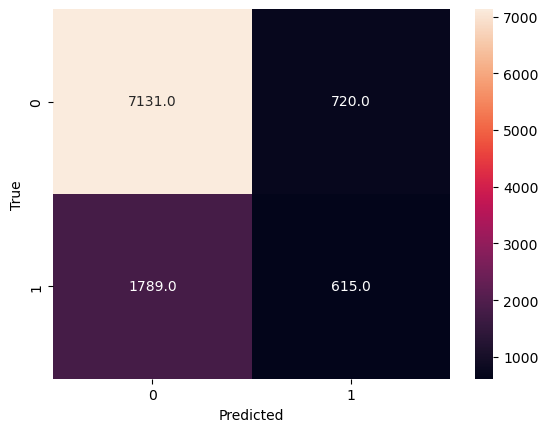

In [31]:
cf_matrix = confusion_matrix(y_test, y_pred)
draw_confusion_matrix(cf_matrix)
# Sensitivity: 0.5632279534109818, Specificity: 0.7223283658132722

In [57]:
model.save('best.h5')

321/321 [==============================] - 1s 3ms/step
Sensitivity: 0.7745424292845258, Specificity: 0.7753152464654184



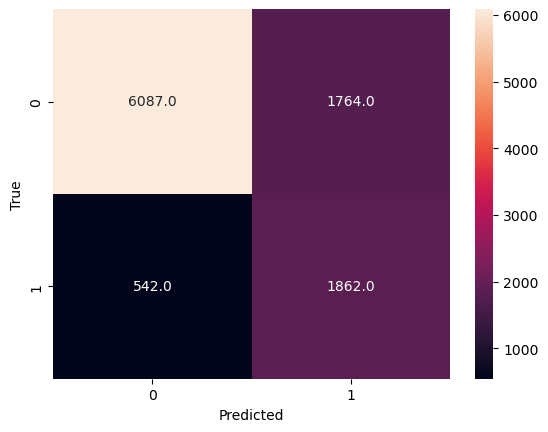

In [29]:
model = tf.keras.models.load_model('best77-77.h5')
y_pred = model.predict(X_test)
y_pred = [1 if i >= 0.5 else 0 for i in y_pred]
cf_matrix = confusion_matrix(y_test, y_pred)
draw_confusion_matrix(cf_matrix)


# Self-Training

In order to prevent some of the common pitfalls of self-labeling and self-training like wrong estimations with high confidence, we'll implement an algorithm called "Batch Learning" (Mikos, 2017).

## Representative Samples

First, we have to get representative samples from our dataset. This is obtained by calculating the euclidean distance between our dataset and its mean.

In [30]:
X = freq_df.values.reshape((int(freq_df.shape[0] / WINDOW_LENGTH), WINDOW_LENGTH, freq_df.shape[1]))
X.shape

(137745, 256, 9)

In [31]:
# Calculates euclidean distance for each columns in dataset, then sorts them to obtain the sample with smallest distance
distances = abs(X-X.mean(axis=0))

sorted_index = distances.sum(axis=1).sum(axis=1).argsort()
sorted_index

array([111377, 111376,   6761, ...,  35231,  35219,  35230])

We collect a representative positive and negative sample, then calculate the euclidean distance between them and divide by 4 to create a "safe zone". During learning, any samples that falls inside a label's safe zone that has an opposite label is discarded. This mitigates the risk of the model deviating too much from the offline learning phase.

![title](images/safe_zone.png)

In [32]:
y_all = freq_df.index.get_level_values('label').values.astype(int)
y_all = y_all[range(0, y_all.shape[0], WINDOW_LENGTH)]
y_sorted = y_all[sorted_index]
y_sorted

array([0, 0, 0, ..., 1, 1, 1])

In [36]:
X_sorted = X[sorted_index]

In [37]:
with open('representative_samples.npy', 'wb') as f:
    np.save(f, X_sorted[:500])


In [38]:
with open('representative_samples.npy', 'rb') as f:
    a = np.load(f)
    print(a.shape)

(500, 256, 9)


In [39]:
neg_index = np.argwhere(y_sorted == 0)
pos_index = np.argwhere(y_sorted == 1)

X_sorted_neg = X_sorted[neg_index]
X_sorted_pos = X_sorted[pos_index]

rep_neg_sample = X_sorted_neg[0]
rep_pos_sample = X_sorted_pos[0]

print(rep_neg_sample.shape, rep_pos_sample.shape)

(1, 256, 9) (1, 256, 9)


In [40]:
safe_zone = abs(rep_neg_sample - rep_pos_sample) / 4
safe_zone

array([[[ 25.25,  61.25,  76.75, ...,  17.  ,   0.  ,  14.75],
        [111.  ,   7.5 ,  52.  , ...,   7.25,  31.  ,  29.25],
        [ 47.75,  14.75,  42.  , ...,  29.25,  50.  ,  31.5 ],
        ...,
        [ 25.25,  24.5 ,   5.  , ...,   7.25,   0.  ,  12.25],
        [ 58.  ,  14.75,  62.  , ...,   9.75,   9.75,  22.  ],
        [ 70.75,  10.  ,  32.25, ...,  12.25,   2.5 ,  14.5 ]]])

I'll also collect 5 representative samples which will be used in the batch learning phase so that the learning process isn't completely unsupervised  

In [41]:
X_offline_neg = X_sorted_neg[:5].reshape(-1, WINDOW_LENGTH, len(sensors))
X_offline_pos = X_sorted_pos[:5].reshape(-1, WINDOW_LENGTH, len(sensors))

# X_stack = np.vstack((rep_neg_samples, rep_pos_samples))
# y_stack = np.vstack((y_sorted[neg_index][:5], y_sorted[pos_index][:5]))
# X_rep, y_rep = shuffle(X_stack, y_stack)

# X_rep = X_rep.reshape(X_rep.shape[0], WINDOW_LENGTH, len(sensors))
# y_rep = y_rep.reshape(-1)

print(X_offline_neg.shape, X_offline_pos.shape)

(5, 256, 9) (5, 256, 9)


## Batch Learning

![title](images/learning_batch.png)

### TFLite Conversion

In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('best77.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmph414rpuc/assets


INFO:tensorflow:Assets written to: /tmp/tmph414rpuc/assets
2022-12-06 13:36:06.220722: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-06 13:36:06.220752: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-06 13:36:06.220880: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph414rpuc
2022-12-06 13:36:06.223765: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-06 13:36:06.223777: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph414rpuc
2022-12-06 13:36:06.233829: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-06 13:36:06.338082: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph414rpuc
2022-12-06 13:36:06.359329: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

Sensitivity: 0.7329450915141431, Specificity: 0.8109794930582092



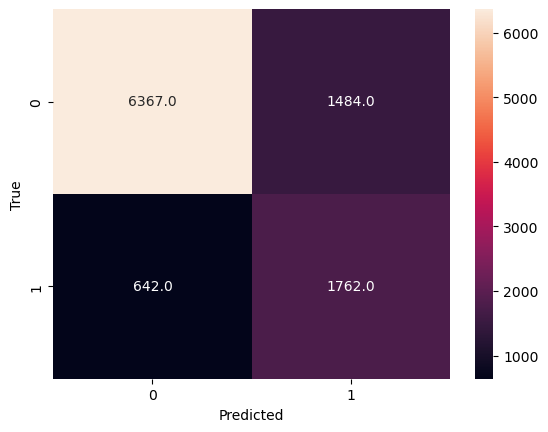

In [68]:
interpreter = tf.lite.Interpreter(model_path='best77.tflite')
interpreter.allocate_tensors()

def classify(interpreter, sample):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    interpreter.set_tensor(input_details[0]['index'], [sample.astype('float32')])
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])
    
    return predictions[0][0]

def evaluate_tflite(interpreter):
    pred_y = np.zeros(X_test.shape[0])

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, sample in enumerate(X_test):
        prediction = classify(interpreter, sample)
        pred_y[i] = prediction
    return pred_y

# y_pred = [1 if i >= 0.5 else 0 for i in evaluate_tflite(interpreter)]
# cf_matrix = confusion_matrix(y_test, y_pred)
# draw_confusion_matrix(cf_matrix)

In [65]:
y_test = y_test.reset_index(drop=True)
y_test[1570:].value_counts()

0    6281
1    2404
dtype: int64

In [79]:
X_online_neg = []
X_online_pos = []

# Deep copy of offline training model
offline_model = tf.keras.models.load_model('best77-77.h5')

y_pred = []
# for i, sample in enumerate(X_test[:10]):
#     predictions = offline_model.predict(np.array([sample]), verbose=0)[0]
#     highest_pred = predictions.argmax()
    
#     prediction = predictions[highest_pred] if highest_pred == 1 else 1 - predictions[highest_pred]
#     y_pred = np.append(y_pred, prediction)

y_pred = np.zeros(10)

for i, sample in enumerate(X_test[1570:]):
    prediction = offline_model.predict(np.array([sample]), verbose=0)[0][0]
    # highest_pred = 1 if prediction >= 0.5 else 0 
    
    pred_mean = np.array(y_pred[-10:]).mean()
    if pred_mean >= 0.5 and y_test[i+1570] == 0:
        print(pred_mean, y_test[i+1570])
    # print("(%.2f %d)", pred_mean.shape, y_test.iloc[i])
    
    if pred_mean > .70:
        print(f'sus sus amogus: {prediction}')
        y_pred = np.append(y_pred, prediction)
        X_online_pos.append(sample)
    elif pred_mean < .25:
        y_pred = np.append(y_pred, prediction)
        X_online_neg.append(sample)
    else:
        y_pred = np.append(y_pred, prediction)
        continue
    
    if len(X_online_pos) >= 5 and len(X_online_neg) >= 5:
        print("HORA DE TREINAR!")
        X_stack = np.vstack((X_online_pos[-5:], X_offline_pos, X_online_neg[-5:], X_offline_neg))
        y_stack = np.ravel((np.ones(10), np.zeros(10)))
        X_batch, y_batch = shuffle(X_stack, y_stack)
        print(X_batch.shape, y_batch.shape)
        offline_model.fit(X_batch, y_batch, epochs=200, batch_size=20, verbose=1)
        # Remove os últimos 5 de cada array
        X_online_pos = X_online_pos[:-5]
        X_online_neg = X_online_neg[:-5]

#     Não dá pra aplicar o Rep Sample, porque eu tirei a média da base inteira e não em batch 256. 
#     Preciso encontrar o batch 256 que é média, se é que isso faz sentido
#     if highest_pred == 1 and np.all(sample > rep_pos_sample + safe_zone or sample < rep_pos_sample - safe_zone):
#         break
#     elif highest_pred == 0 and np.all(sample > rep_neg_sample + safe_zone or sample < rep_pos_sample - safe_zone):
#         break
#     break

0.5377690315246582 0
0.5040182620286942 0
0.5100936233997345 0
0.5149346888065338 0
0.5200582593679428 0
0.5268945455551147 0
0.5342941343784332 0
0.5418721079826355 0
0.5497338831424713 0
0.5582207679748535 0
0.5670279920101166 0
0.5756827592849731 0
0.5848899781703949 0
0.5938145756721497 0
0.6022884905338287 0
0.6089271783828736 0
0.6138930499553681 0
0.6177079021930695 0
0.6203494489192962 0
0.6219708621501923 0
0.62303586602211 0
0.6239795506000518 0
0.6238216936588288 0
0.6229990243911743 0
0.6209490418434143 0
0.6184783399105072 0
0.6161865532398224 0
0.6138770282268524 0
0.6108922243118287 0
0.6076605558395386 0
0.6040675818920136 0
0.6006293296813965 0
0.5978000938892365 0
0.5963629007339477 0
0.5967323839664459 0
0.5976792514324188 0
0.598733413219452 0
0.6001330256462097 0
0.6025747776031494 0
0.6056002736091614 0
0.6086956918239593 0
0.611251026391983 0
0.6129193127155304 0
0.6125588834285736 0
0.6110145807266235 0
0.6089638352394104 0
0.6068263292312622 0
0.604506170749664

# 'Leave One Out' Cross Validation

In [ ]:
frame = freq_df.index.to_frame()
freq_df[frame['subject'].isin(train_subjects)]

ank_hor_fwd  ank_vert  ank_hor_lat  leg_hor_fwd  \
subject label time_step                                                    
1       0.0   0               -101.0     980.0        326.0       -136.0   
              1                -80.0    1000.0        326.0       -100.0   
              2                -70.0     990.0        336.0        -81.0   
              3                -90.0     990.0        306.0        -81.0   
              4                -50.0     990.0        316.0       -100.0   
...                              ...       ...          ...          ...   
9       0.0   251              191.0     990.0        158.0       -627.0   
              252              191.0    1000.0        158.0       -636.0   
              253              171.0    1000.0        178.0       -636.0   
              254              191.0    1009.0        148.0       -636.0   
              255              191.0    1009.0        148.0       -627.0   

                         leg_vert  leg_hor_lat  trunk_hor_fwd  trunk_vert  \
subject label time_step                                                     
1       0.0   0             972.0        181.0          -48.0      1019.0   
              1             962.0        181.0          -58.0      1019.0   
              2             972.0        212.0          -58.0      1009.0   
              3             981.0        202.0          -58.0      1009.0   
              4             962.0        202.0          -48.0      1028.0   
...                           ...          ...            ...         ...   
9       0.0   251           444.0        595.0         -155.0       961.0   
              252           472.0        606.0         -145.0       980.0   
              253           462.0        616.0         -135.0       980.0   
              254           453.0        616.0         -145.0       971.0   
              255           453.0        616.0         -145.0       980.0   

                         trunk_hor_lat  
subject label time_step                 
1       0.0   0                   -9.0  
              1                  -58.0  
              2                    0.0  
              3                    0.0  
              4                  -29.0  
...                                ...  
9       0.0   251                281.0  
              252                242.0  
              253                271.0  
              254                262.0  
              255                252.0  

[32637440 rows x 9 columns]

In [25]:
sensitivity_scores = []
specificity_scores = []
total_cf_matrix = np.zeros((2,2))

for test_subject in subjects:
    train_subjects = subjects - set([test_subject])
    index_frame = freq_df.index.to_frame()

    train_df = freq_df[index_frame['subject'].isin(train_subjects)]
    test_df = freq_df[index_frame['subject'] == test_subject]

    X_train = train_df.values.reshape((int(train_df.shape[0] / WINDOW_LENGTH), WINDOW_LENGTH, train_df.shape[1]))
    X_test = test_df.values.reshape((int(test_df.shape[0] / WINDOW_LENGTH), WINDOW_LENGTH, test_df.shape[1]))
    y_train = pd.Series(train_df.index.get_level_values(1).values.astype(int))
    y_train = y_train[range(0, y_train.shape[0], WINDOW_LENGTH)]
    y_test = pd.Series(test_df.index.get_level_values(1).values.astype(int))
    y_test = y_test[range(0, y_test.shape[0], WINDOW_LENGTH)]

    X_train_under, y_train_under = random_undersampling(X_train, y_train)

    model = get_custom_model(X_train_under, False)
    print(f'Testing patient {test_subject}')
    run_training(X_train_under, y_train_under, X_test, y_test, model, plot=False, verbose=0)
    
    y_pred = model.predict(X_test)
    y_pred = [1 if i >= 0.5 else 0 for i in y_pred]
    cf_matrix = confusion_matrix(y_test, y_pred)
    total_cf_matrix += cf_matrix
    sensitivity, specificity = sensitivity_specificity(cf_matrix)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

    tf.keras.backend.clear_session()
    print(' The results for test subject {:} are Sensitivity {:.2%} and Specificity {:.2%}'.format(test_subject, sensitivity, specificity))

Testing patient 1
635/635 [==============================] - 2s 3ms/step
 The results for test subject 1 are Sensitivity 46.73% and Specificity 81.87%
Testing patient 2
501/501 [==============================] - 2s 3ms/step
 The results for test subject 2 are Sensitivity 58.40% and Specificity 70.77%
Testing patient 3
516/516 [==============================] - 2s 3ms/step
 The results for test subject 3 are Sensitivity 82.48% and Specificity 71.68%
Testing patient 5
691/691 [==============================] - 2s 3ms/step
 The results for test subject 5 are Sensitivity 55.44% and Specificity 86.45%
Testing patient 6
557/557 [==============================] - 2s 3ms/step
 The results for test subject 6 are Sensitivity 23.32% and Specificity 98.70%
Testing patient 7
629/629 [==============================] - 2s 3ms/step
 The results for test subject 7 are Sensitivity 61.86% and Specificity 94.52%
Testing patient 8


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
df = pd.DataFrame({'id':list(subjects), 'Sensitivity':sensitivity_scores, 'Specificity':specificity_scores})
df.plot(x="id", y=["Sensitivity", 'Specificity'], kind="bar")

In [ ]:
print('Average Sensitivity {:.2%} and Specificity {:.2%}'.format(sum(sensitivity_scores) / len(sensitivity_scores), sum(specificity_scores) / len(specificity_scores)))

In [ ]:
draw_confusion_matrix(total_cf_matrix)